# Comparisson between different pre trained models on ImageNet

## Common Parameters

In [54]:
sys.path.append("..") # Adds higher directory to python modules path.
from PIL import features, Image
from packaging import version
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
import tensorflow.keras
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data import *
from collections import Counter
from data.data_loader import *
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, recall_score, accuracy_score, roc_auc_score
from helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019/sampled_unbalanced_5000'

model_folder = 'models'
history_folder = 'history'
pred_result_folder_test = 'test_predict_results'
out_dist_pred_result_folder = 'out_dist_predict_results'

#hyperparameter_str = formated_hyperparameter_str(0, 1e-4, 1e-4, None, None, 32, 5000, 0)

models_info = read_models_info(history_folder, pred_result_folder_test)

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 5000 samples.
'MEL':	892	(17.84%)
'NV':	2541	(50.82%)
'BCC':	655	(13.10%)
'AK':	171	(3.42%)
'BKL':	517	(10.34%)
'DF':	47	(0.94%)
'VASC':	49	(0.98%)
'SCC':	128	(2.56%)
'UNK':	0	(0.00%)


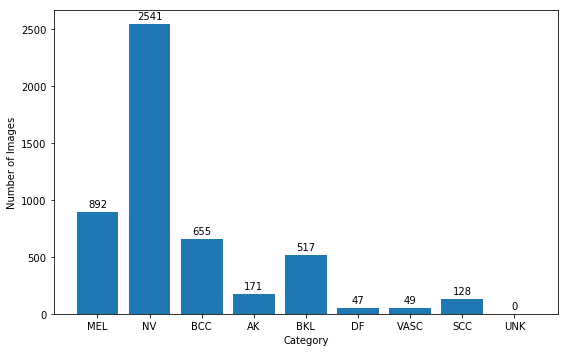

In [55]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

df_all_ground_truth, _, _ = load_isic_training_data(
    "../data/isic2019/ISIC_2019_Training_Input", 
    "../data/isic2019/ISIC_2019_Training_GroundTruth.csv"
)

### Shuffle and Split Training Data into Training  and Validation Sets

In [42]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 4000 samples.
'MEL':	714	(17.85%)
'NV':	2033	(50.83%)
'BCC':	524	(13.10%)
'AK':	137	(3.42%)
'BKL':	414	(10.35%)
'DF':	37	(0.93%)
'VASC':	39	(0.97%)
'SCC':	102	(2.55%)
'UNK':	0	(0.00%)

Validation set has 1000 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.700280
'NV':	0.245942
'BCC':	0.954198
'AK':	3.649635
'BKL':	1.207729
'DF':	13.513514
'VASC':	12.820513
'SCC':	4.901961


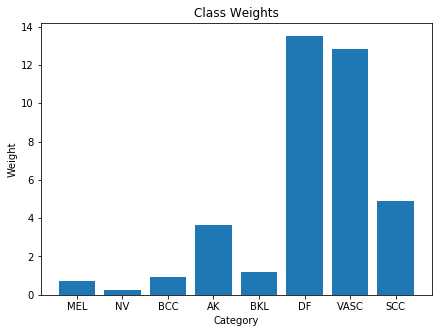

In [30]:
class_weight_dict, class_weights = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weight_dict[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weight_dict[i] for i in range(known_category_num)]);

## Transfer Learning

### Complexity Graph of Transfer Learning Models

../history/DenseNet201/DenseNet201.training.csv
../history/EfficientNetB0/EfficientNetB0.training.csv
../history/EfficientNetB1/EfficientNetB1.training.csv
../history/EfficientNetB2/EfficientNetB2.training.csv
../history/EfficientNetB3/EfficientNetB3.training.csv
../history/EfficientNetB4/EfficientNetB4.training.csv
../history/VGG16/VGG16.training.csv
../history/VGG19/VGG19.training.csv
../history/ResNet50/ResNet50.training.csv


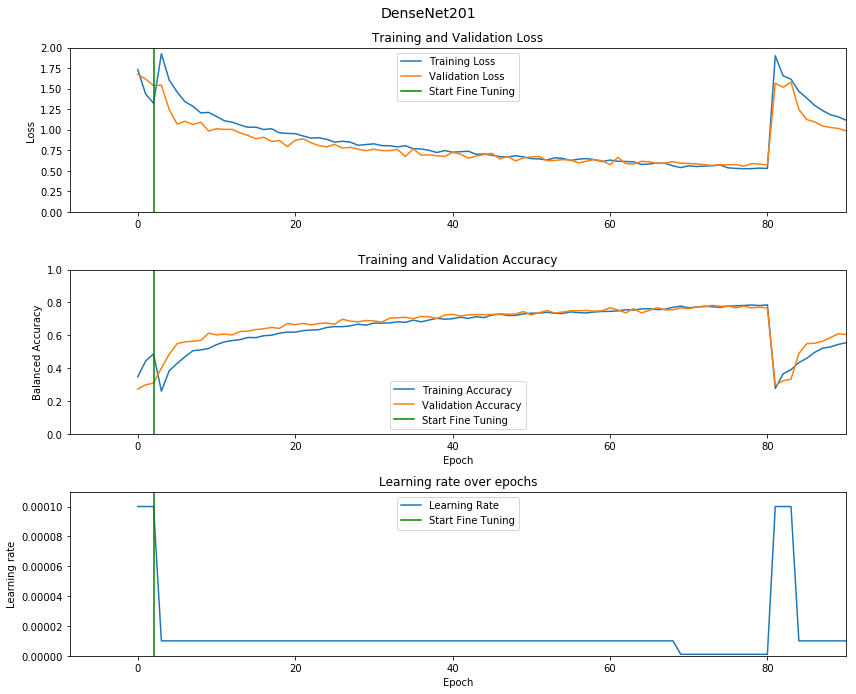

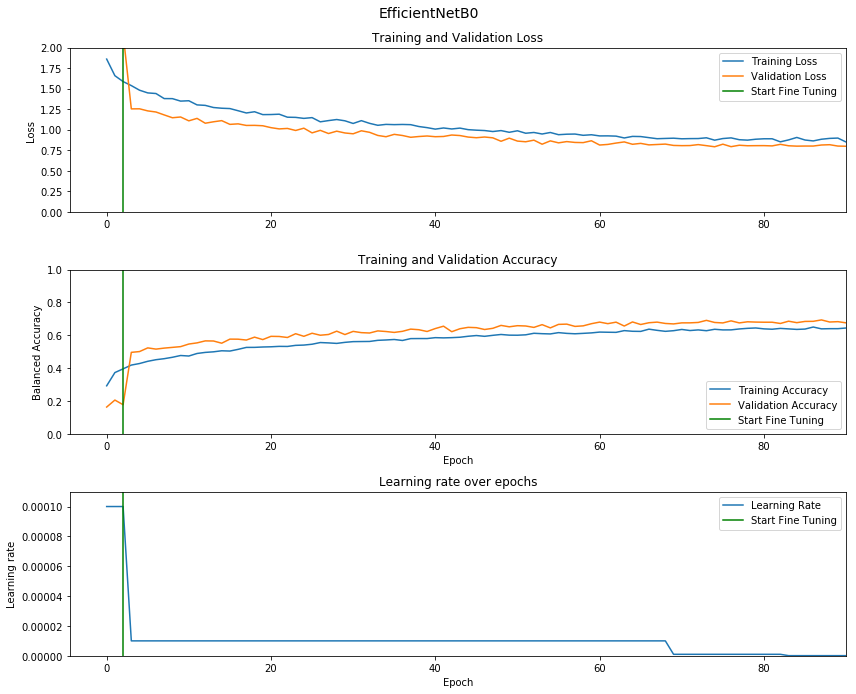

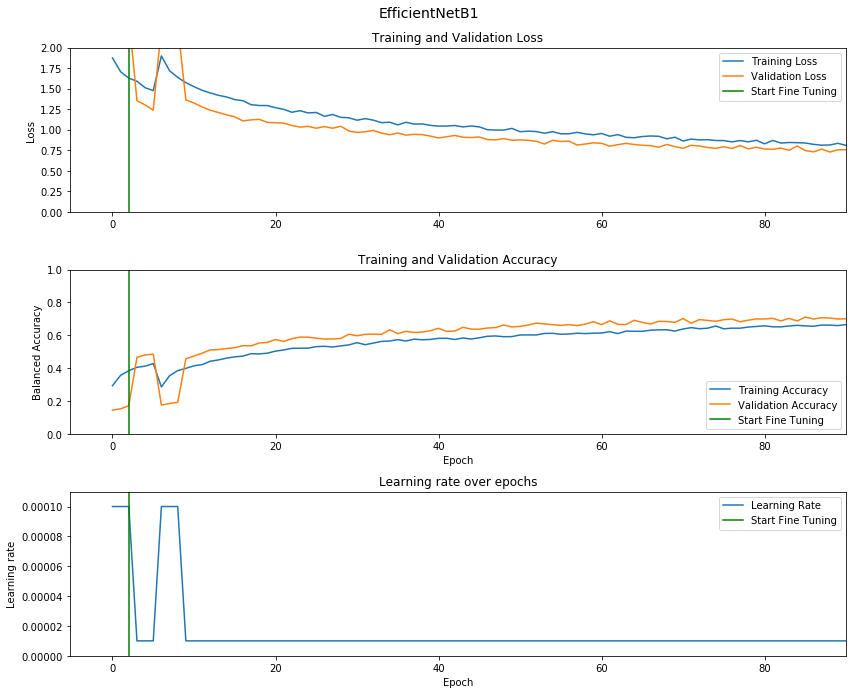

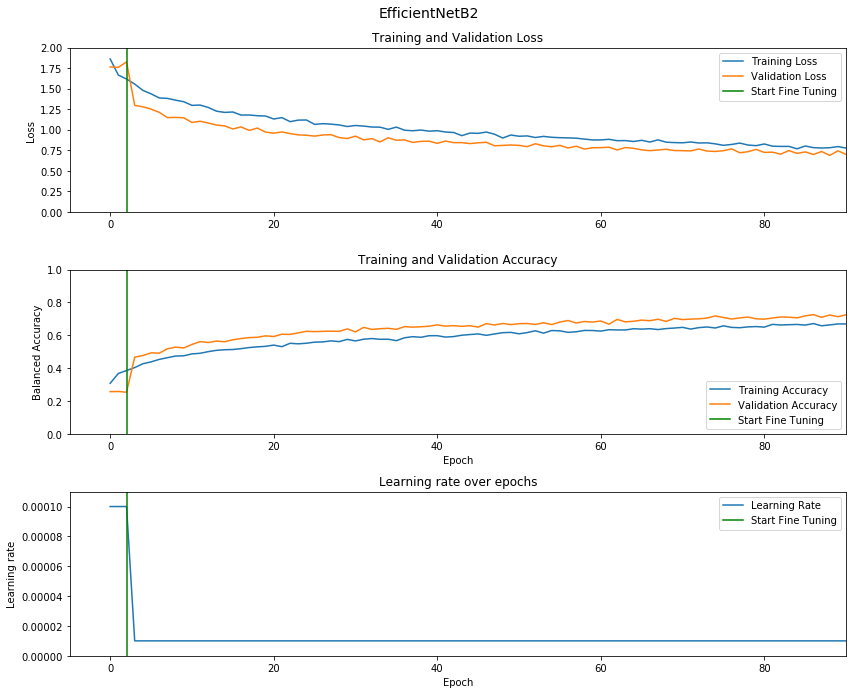

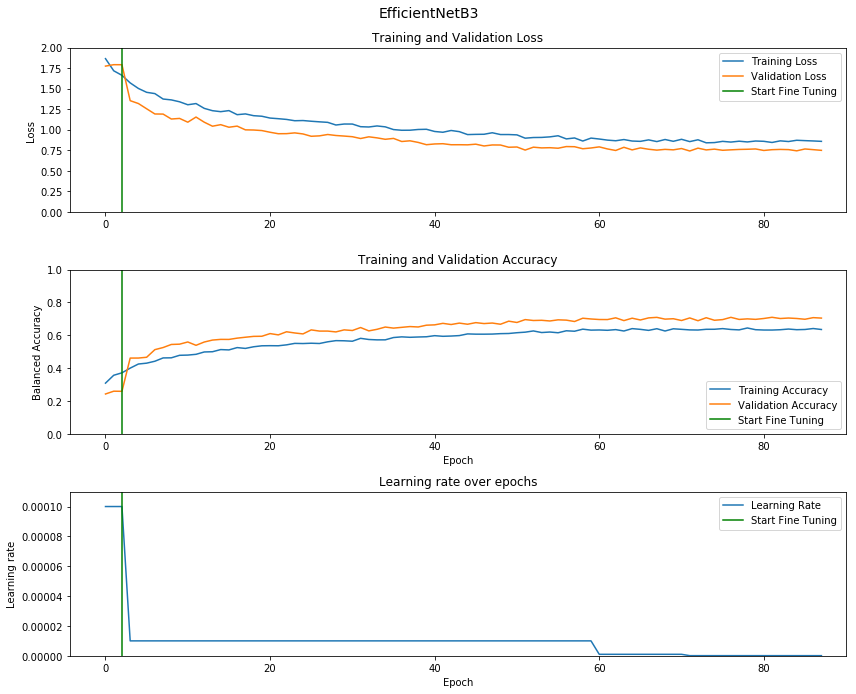

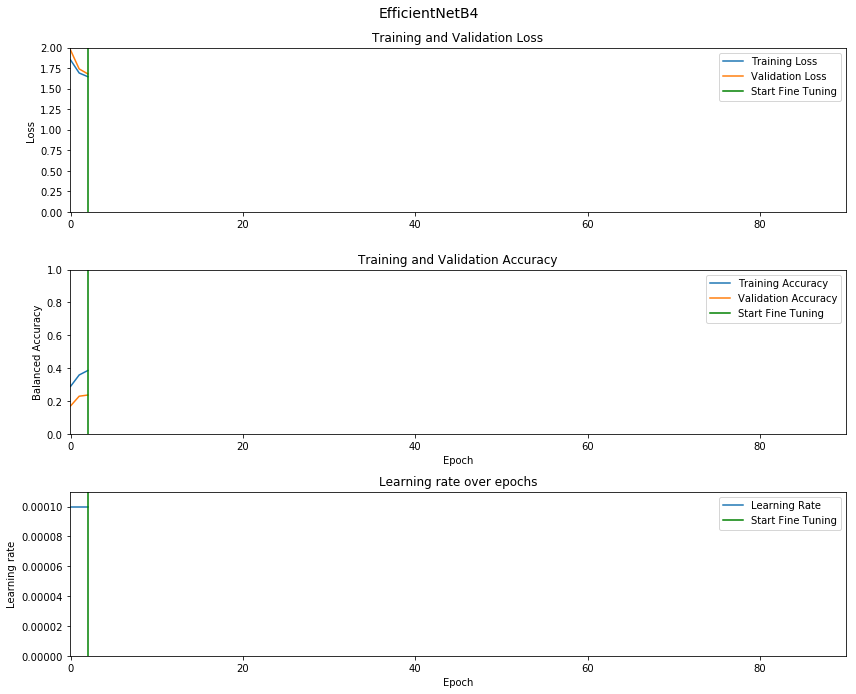

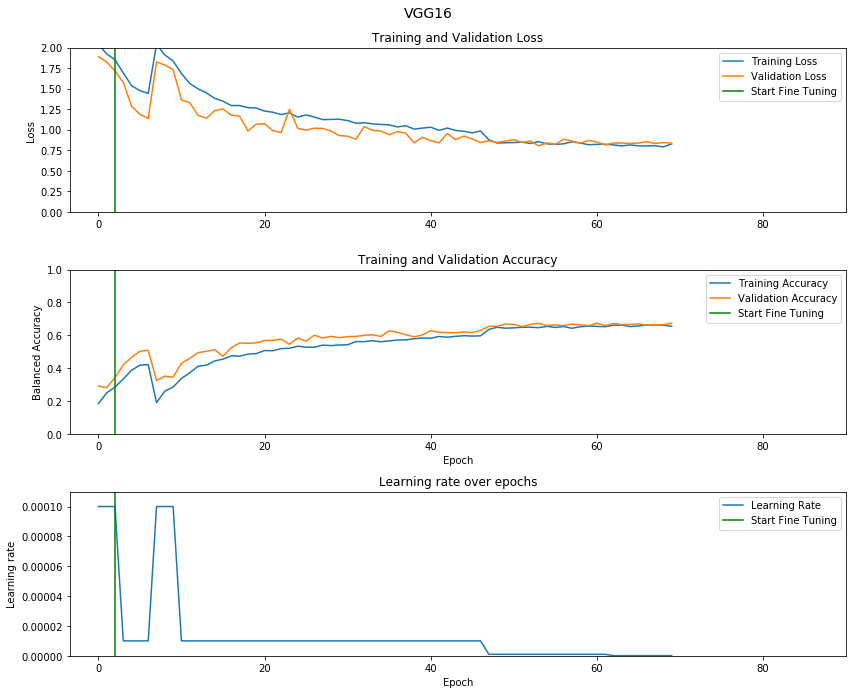

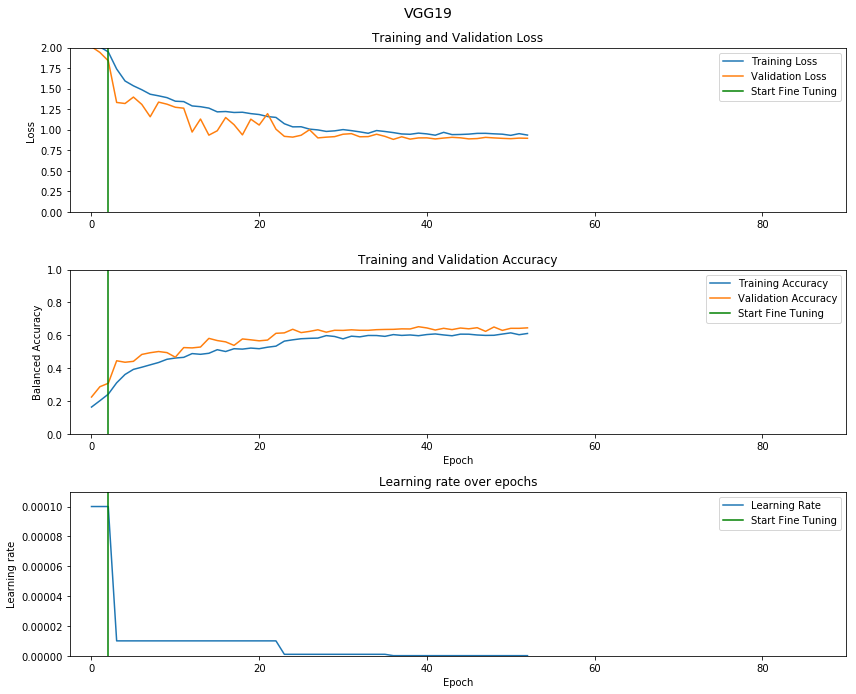

In [13]:
model_names = ['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'VGG16', 'VGG19', 'ResNet50']
feature_extract_epochs = 3

for model_name in model_names:
    file_path = os.path.join("..", history_folder, model_name, "{}.training.csv".format(model_name))
    print(file_path)
    if os.path.exists(file_path):
        fig = plot_complexity_graph(csv_file=file_path,
                              title="{}".format(model_name),
                              figsize=(12, 10),
                              feature_extract_epochs=feature_extract_epochs)
        fig.savefig(os.path.join("..", history_folder, model_name, "{}.training.svg".format(model_name)), format='svg',
                    bbox_inches='tight', pad_inches=0)

### Classify Dermoscopic Images using Transfer Learning Models

In [ ]:
import random
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from utils import path_to_tensor
from base_model_param import get_transfer_model_param_map
from lesion_classifier import LesionClassifier
from metrics import balanced_accuracy
from pathlib import Path

def transfer_classify(model, img_path, data_format, augmentation_pipeline, preprocessing_function, topk=8):
    img = Image.open(img_path) # PIL Image
    img = augmentation_pipeline.perform_operations(img)
    img = img_to_array(img, data_format=data_format, dtype='float32')
    img = preprocessing_function(img, data_format=data_format)
    img = np.expand_dims(img, axis=0)
    predicted_vector = model.predict(img)
    idx_topk = np.argsort(-predicted_vector)[0, :topk]
    probs = np.take(predicted_vector, idx_topk)
    names = [known_category_names[idx] for idx in idx_topk]
    return idx_topk, names, probs

topk = known_category_num
model_param_map = get_transfer_model_param_map()
model_name = 'DenseNet201'
model = load_model(filepath=os.path.join("..", model_folder, "{}_best_balanced_acc.hdf5".format(model_name)),
                   custom_objects={'balanced_accuracy': balanced_accuracy(known_category_num)})
augmentation_pipeline = LesionClassifier.create_aug_pipeline_val(model_param_map[model_name].input_size)
preprocessing_function = model_param_map[model_name].preprocessing_func
image_data_format = K.image_data_format()

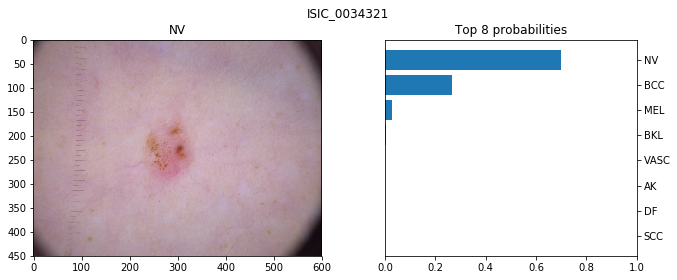

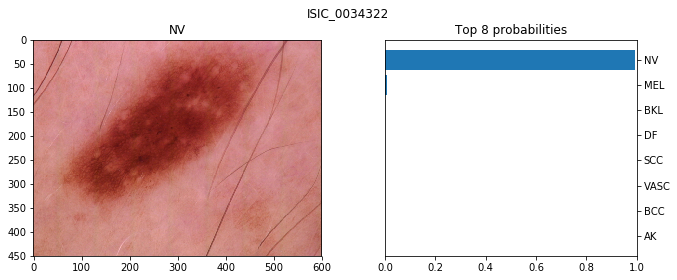

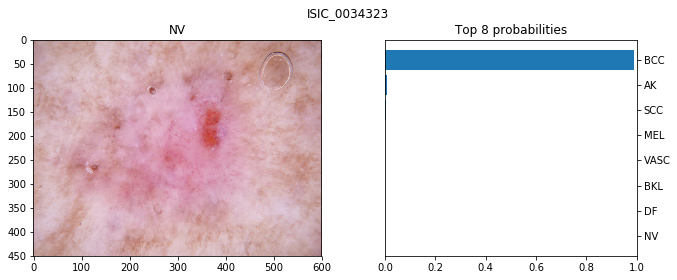

In [10]:
imgs_crop_marker = ['../data/isic2019/ISIC_2019_Test_Input/ISIC_0034321.jpg',
                    '../data/isic2019/ISIC_2019_Test_Input/ISIC_0034322.jpg',
                    '../data/isic2019/ISIC_2019_Test_Input/ISIC_0034323.jpg']

for img_path in imgs_crop_marker:
    idx_topk, names, probs = transfer_classify(model, img_path, image_data_format, augmentation_pipeline, preprocessing_function, topk)
    fig = plot_prob_bars(img_title='NV',
                         img_path=img_path,
                         labels=names,
                         probs=probs,
                         topk=topk,
                         title=Path(img_path).stem)
    fig.savefig("{}_Probs.jpg".format(Path(img_path).stem), format='jpg', dpi=150, bbox_inches='tight', pad_inches=0)

## Predict Validation Set

### Ensemble Models' Predictions on Validation Set

In [25]:
from utils import ensemble_predictions

ensemble_predictions(pred_result_folder_test, known_category_names, model_names=['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3','ResNet50'])

Save "val_predict_results/Ensemble_best_balanced_acc.csv"
Save "val_predict_results/Ensemble_best_loss.csv"
Save "val_predict_results/Ensemble_latest.csv"


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,category,pred_category
0,ISIC_0070596,0.971670,0.015020,0.000430,3.201061e-05,0.012775,0.000028,0.000006,0.000039,0,0
1,ISIC_0061244,0.621627,0.226720,0.002856,2.040082e-03,0.095453,0.000182,0.000017,0.051105,0,0
2,ISIC_0029813,0.001262,0.983259,0.000259,2.659553e-04,0.003006,0.011716,0.000190,0.000042,1,1
3,ISIC_0032739,0.093299,0.888207,0.000028,1.824843e-04,0.011987,0.000729,0.000021,0.005546,1,1
4,ISIC_0064041,0.315752,0.541593,0.002404,4.747990e-03,0.129496,0.001040,0.002870,0.002096,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5062,ISIC_0014612_downsampled,0.038764,0.011641,0.008116,5.926348e-02,0.799843,0.005831,0.000118,0.076425,4,4
5063,ISIC_0000324,0.142297,0.654353,0.000266,2.515551e-03,0.200197,0.000333,0.000009,0.000029,1,1
5064,ISIC_0071830,0.014117,0.000398,0.096192,8.567351e-01,0.002917,0.000037,0.000501,0.029103,3,3
5065,ISIC_0028349,0.003821,0.996065,0.000002,8.873594e-08,0.000013,0.000047,0.000049,0.000002,1,1


### Load Prediction Results on Validation Set

Model selection criteria:  latest
../val_predict_results/VGG16/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== VGG16 ==========
balanced_accuracy_score:  0.6041313851092163
macro recall_score:  0.6041313851092163
categorical_crossentropy:  0.8282701631271616
weighted categorical_crossentropy:  1.4549027196422586

../val_predict_results/VGG19/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== VGG19 ==========
balanced_accuracy_score:  0.5064048953989067
macro recall_score:  0.5064048953989067
categorical_crossentropy:  0.8307733613057584
weighted categorical_crossentropy:  1.6605932923233613

../val_predict_results/ResNet50/balanced_0-samples_5000-feepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32/no_unknown/latest.csv
========== ResNet50 ==========
balanced_accuracy_score:  0.5816995193920573
macro recall_

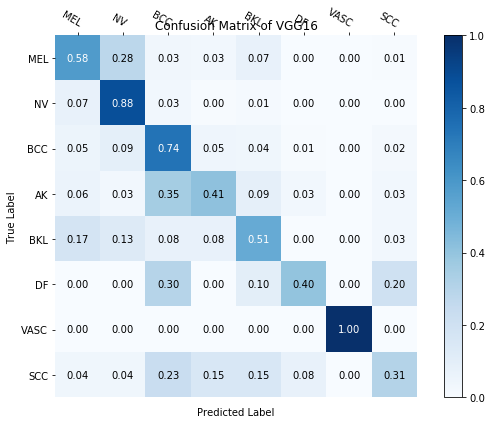

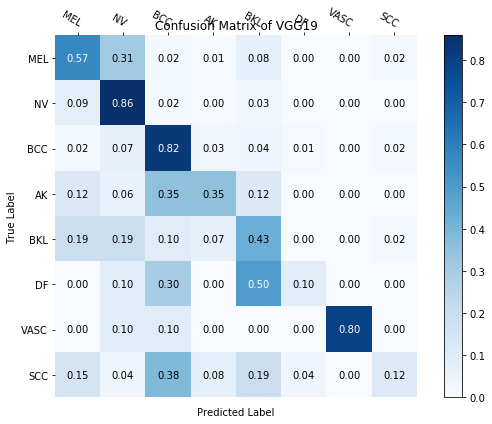

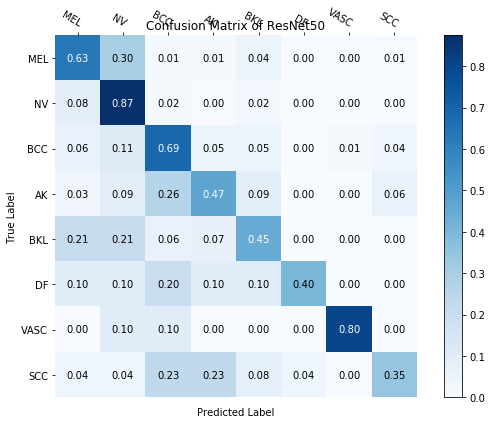

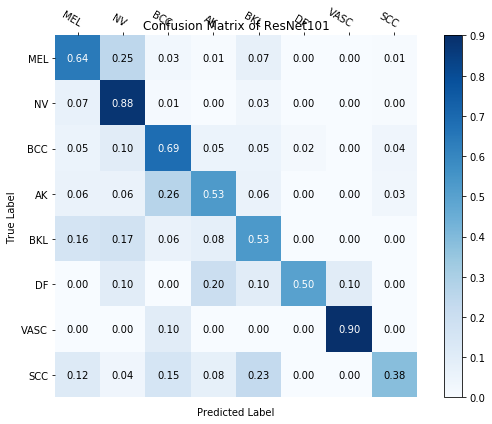

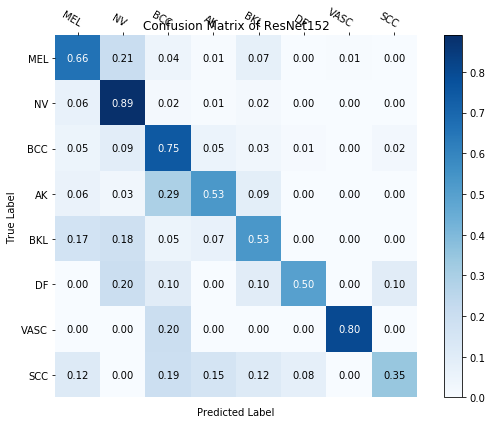

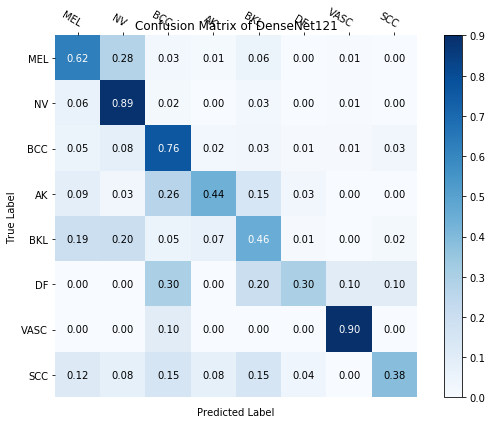

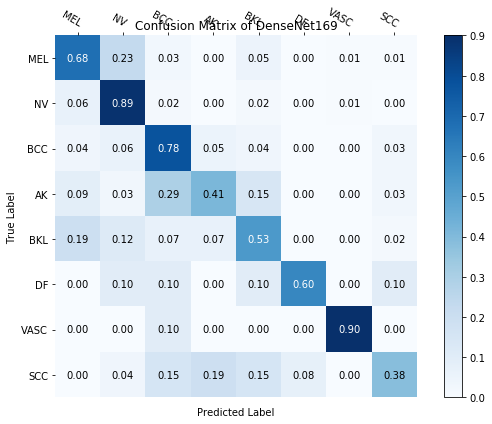

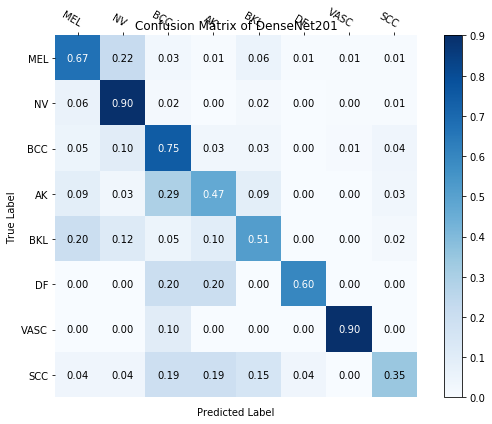

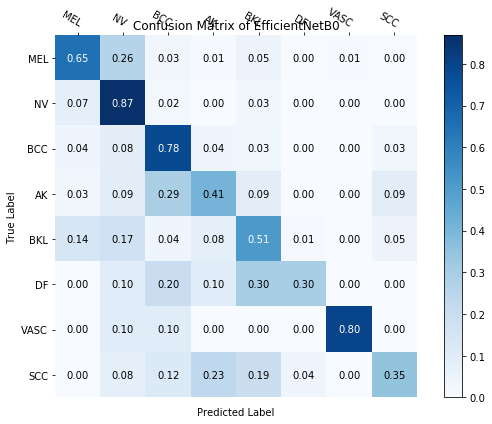

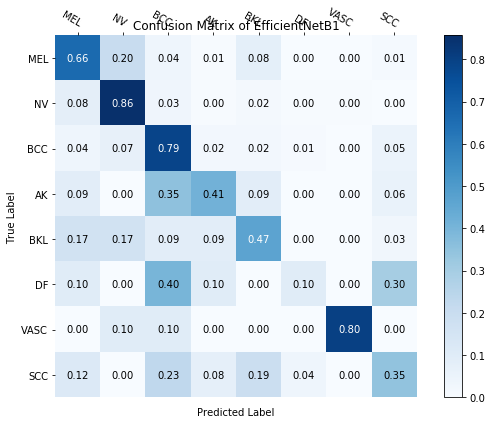

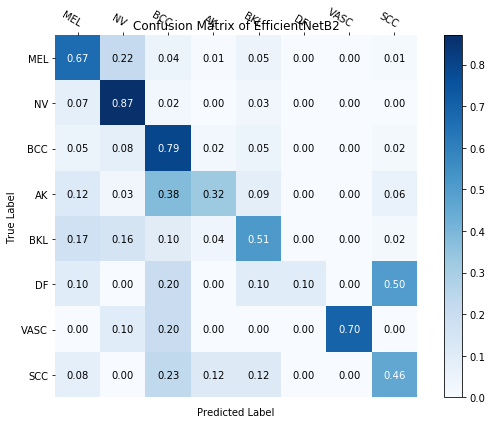

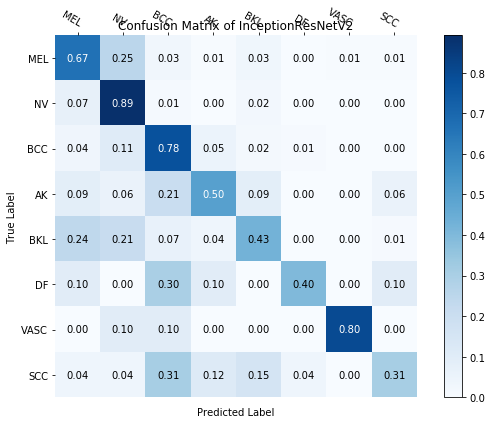

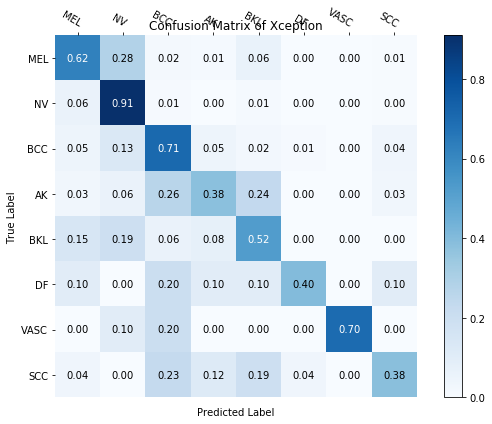

In [31]:
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy
model_names = [
    'VGG16',
    'VGG19',
    'ResNet50',
    'ResNet101',
    'ResNet152',
    'DenseNet121',
    'DenseNet169',
    'DenseNet201', 
    'EfficientNetB0', 
    'EfficientNetB1', 
    'EfficientNetB2', 
    'EfficientNetB3',  
    'InceptionResNetV2', 
    'Xception'
    #'Ensemble'
]

postfix = 'latest'
print('Model selection criteria: ', postfix)

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join("..", pred_result_folder_test, model_name, hyperparameter_str, "no_unknown", "{}.csv".format(postfix))

    print(file_path)
    if not os.path.exists(file_path):
        continue

    print("========== {} ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_true = df['category']
    y_pred = df['pred_category']

    # Compute Balanced Accuracy
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))

    # Compute categorical_crossentropy
    y_true_onehot = utils.to_categorical(df['category'], num_classes=known_category_num)
    y_pred_onehot = np.array(df.iloc[:,1:9])
    print('categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot)))

    # Compute weighted categorical_crossentropy
    print('weighted categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot, class_weights=class_weights)))

    # Confusion Matrix
    fig = plot_confusion_matrix(y_true, y_pred, known_category_names, normalize=True,
                                title="Confusion Matrix of {}".format(model_name),
                                figsize=(8, 6))
    print('')

Validation set has 1000 samples.

========== Ground Truth ==========
'MEL':	178	(17.80%)
'NV':	508	(50.80%)
'BCC':	131	(13.10%)
'AK':	34	(3.40%)
'BKL':	103	(10.30%)
'DF':	10	(1.00%)
'VASC':	10	(1.00%)
'SCC':	26	(2.60%)

========== VGG16 Prediction ==========
'MEL':	168	(16.80%)
'NV':	524	(52.40%)
'BCC':	147	(14.70%)
'AK':	39	(3.90%)
'BKL':	85	(8.50%)
'DF':	8	(0.80%)
'VASC':	10	(1.00%)
'SCC':	19	(1.90%)

========== VGG19 Prediction ==========
'MEL':	176	(17.60%)
'NV':	525	(52.50%)
'BCC':	157	(15.70%)
'AK':	28	(2.80%)
'BKL':	93	(9.30%)
'DF':	3	(0.30%)
'VASC':	8	(0.80%)
'SCC':	10	(1.00%)

========== ResNet50 Prediction ==========
'MEL':	188	(18.80%)
'NV':	539	(53.90%)
'BCC':	124	(12.40%)
'AK':	39	(3.90%)
'BKL':	77	(7.70%)
'DF':	5	(0.50%)
'VASC':	10	(1.00%)
'SCC':	18	(1.80%)

========== ResNet101 Prediction ==========
'MEL':	176	(17.60%)
'NV':	527	(52.70%)
'BCC':	121	(12.10%)
'AK':	39	(3.90%)
'BKL':	100	(10.00%)
'DF':	7	(0.70%)
'VASC':	11	(1.10%)
'SCC':	19	(1.90%)

========== ResNet152 Pre

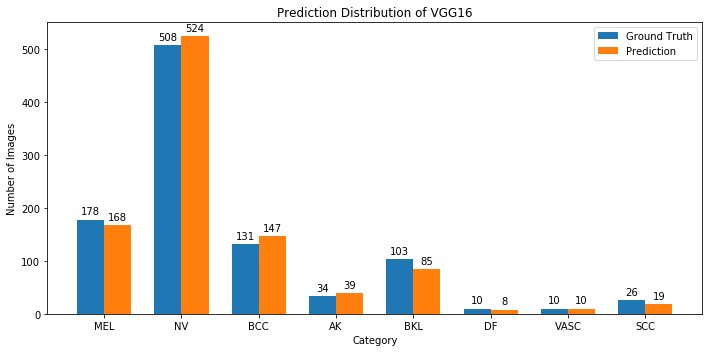

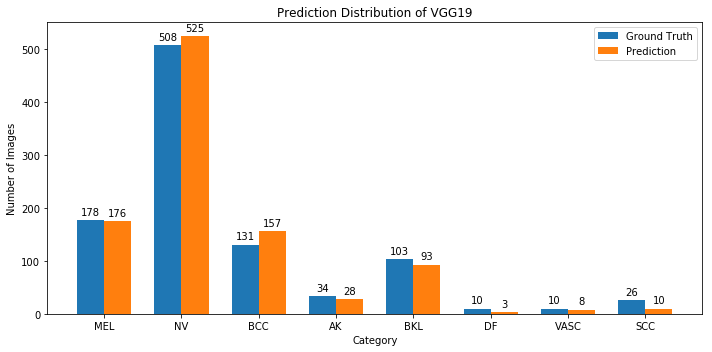

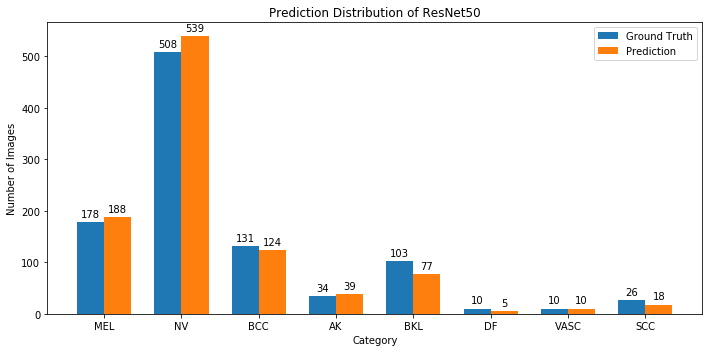

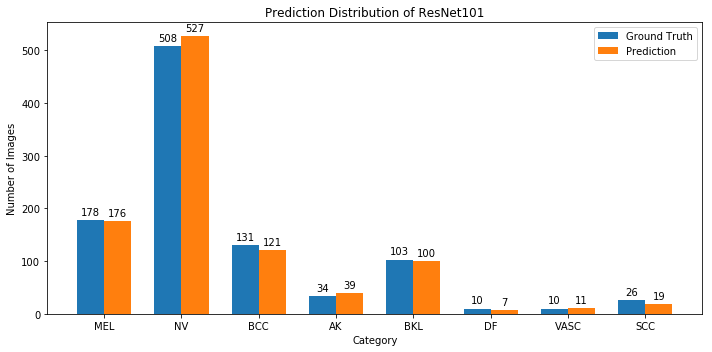

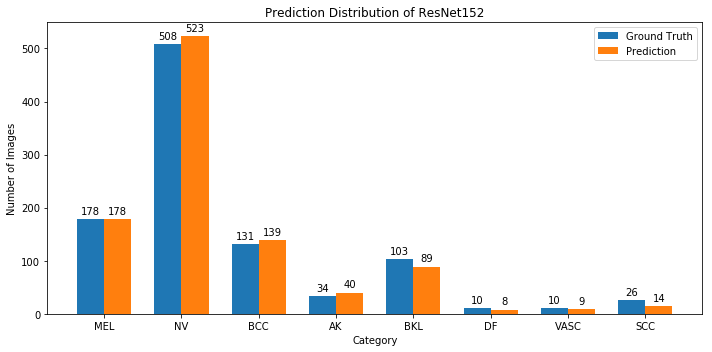

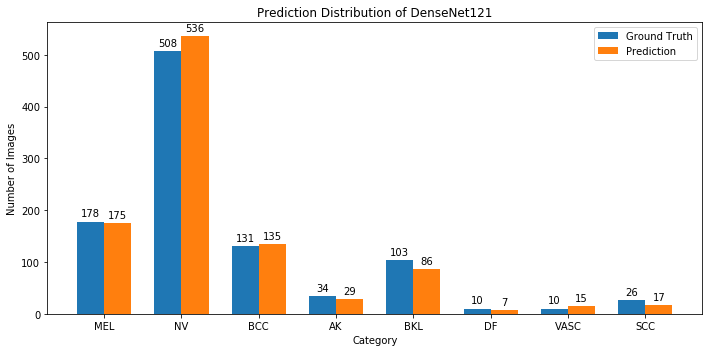

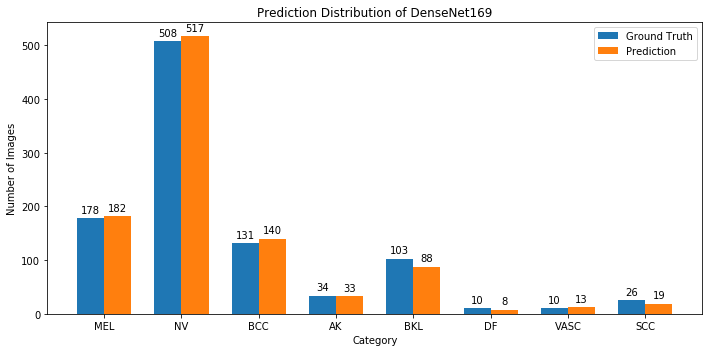

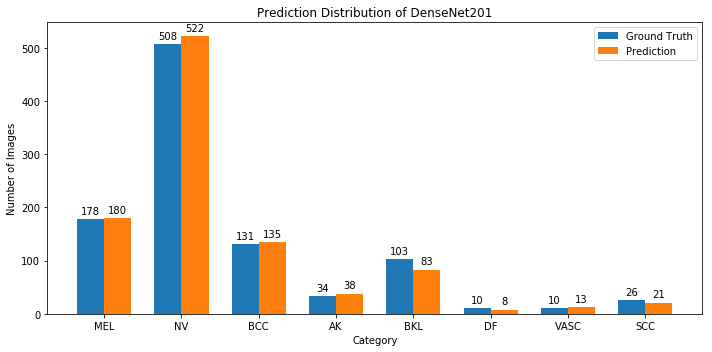

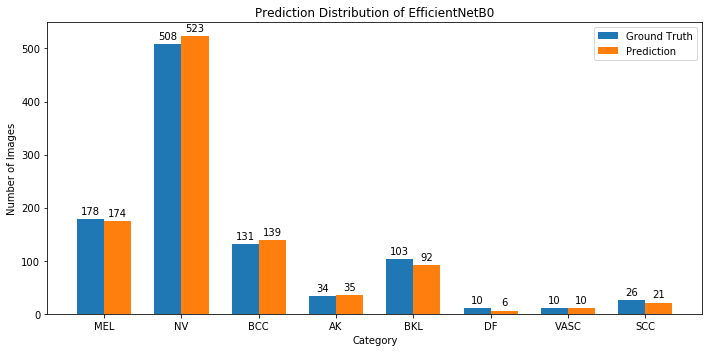

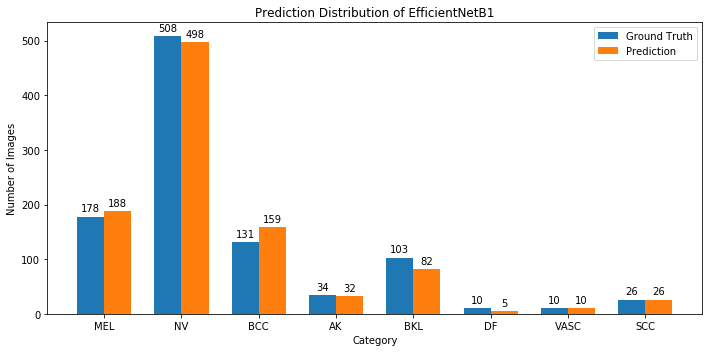

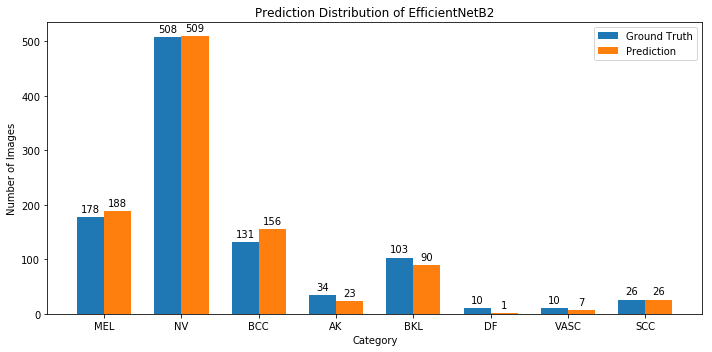

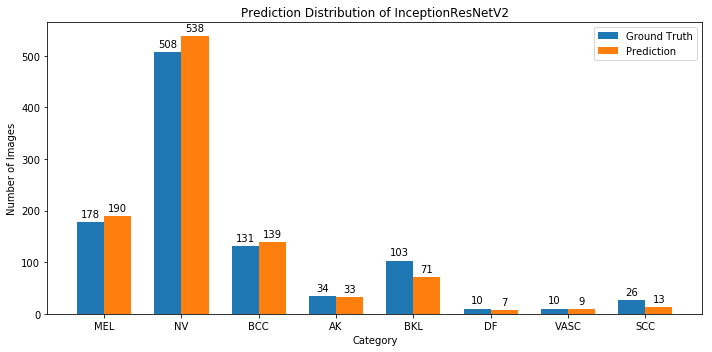

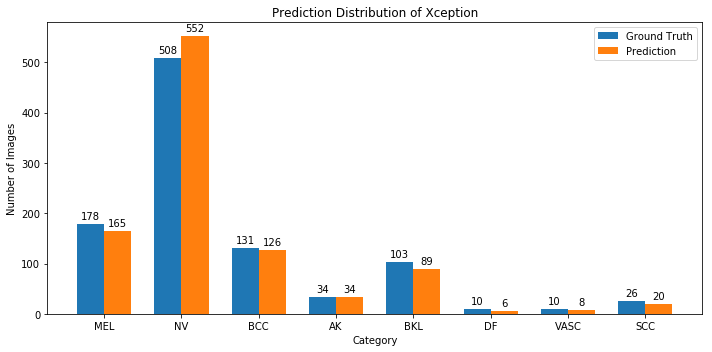

In [33]:
sample_count_val = y_true.shape[0]
print("Validation set has {} samples.\n".format(sample_count_val))

print('========== Ground Truth ==========')
count_true = Counter(y_true)
for i, c in enumerate(known_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_true[i], count_true[i]*100/sample_count_val))

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join("..", pred_result_folder_test, model_name, hyperparameter_str, "no_unknown", "{}.csv".format(postfix))
    if not os.path.exists(file_path):
        continue

    print("\n========== {} Prediction ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_pred = df['pred_category']
    
    count_pred = Counter(y_pred)
    for i, c in enumerate(known_category_names):
        print("'%s':\t%d\t(%.2f%%)" % (c, count_pred[i], count_pred[i]*100/sample_count_val))

    # Plot Prediction Distribution
    plot_grouped_2bars(
        scalars=[[count_true[i] for i in range(known_category_num)],
                 [count_pred[i] for i in range(known_category_num)]],
        scalarlabels=['Ground Truth', 'Prediction'],
        xticklabels=known_category_names,
        xlabel='Category',
        ylabel='Number of Images',
        title="Prediction Distribution of {}".format(model_name)
    )

{'model': 'VGG16', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '100', 'ftepochs': '0', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/VGG16/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_val': None, 'pred_test': '../test_predict_results/VGG16/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01'}
{'model': 'ResNet152', 'hyperparameters': {'balanced': '0', 'samples': '5000', 'feepochs': '100', 'ftepochs': '0', 'felr': '0.000100', 'ftlr': '0.000100', 'lambda': 'None', 'dropout': 'None', 'batch': '32', 'dggroup': '01'}, 'log': '../history/ResNet152/balanced_0-samples_5000-feepochs_100-ftepochs_0-felr_0.000100-ftlr_0.000100-lambda_None-dropout_None-batch_32-dggroup_01/0/training.csv', 'pred_val': None, 'pred_test': '../test

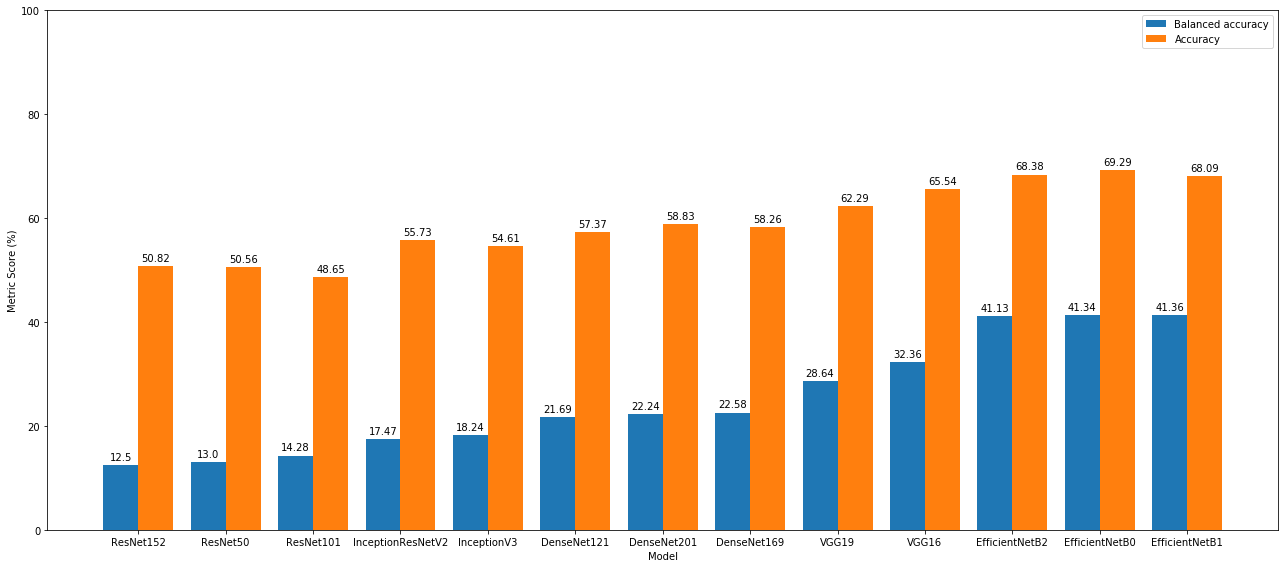

In [47]:
#print(models_info)
fig = plot_model_comparisson(
    models_info, 
    df_all_ground_truth,
    [balanced_accuracy_score, accuracy_score],
    ["Balanced accuracy", "Accuracy"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "100",
        "ftepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
        "dggroup": "01"
    },
    figsize = (18,8)
)

fig.savefig(os.path.join("pre_trained_models_classifier_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

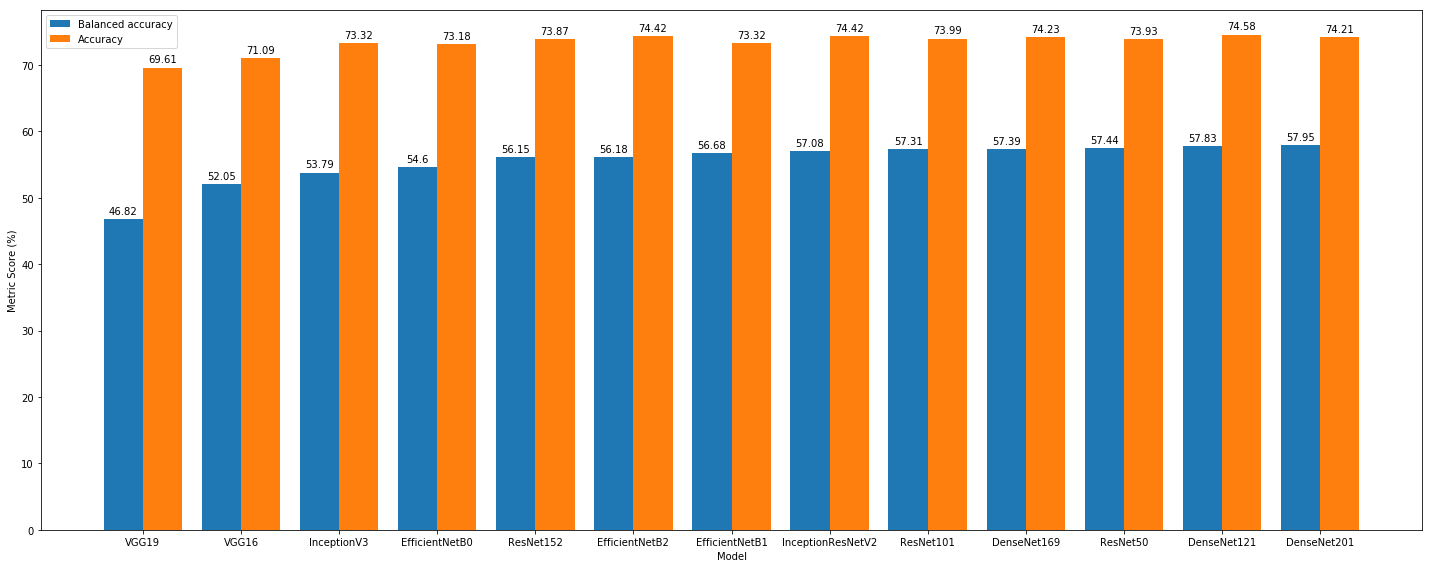

In [51]:
fig = plot_model_comparisson(
    models_info, 
    df_all_ground_truth,
    [balanced_accuracy_score, accuracy_score],
    ["Balanced accuracy", "Accuracy"],
    constant_parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftepochs": "100",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32,
    },
    figsize = (20,8),
    y_max=None
)

fig.savefig(os.path.join("pre_trained_models_ft_comp.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

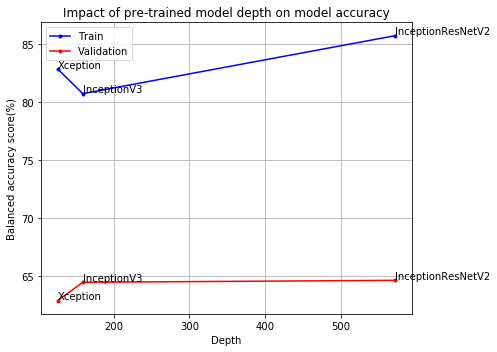

In [84]:
# Trainable params
model_layers = {
    'Xception': 126,  
    "InceptionV3": 159,
    'InceptionResNetV2': 572, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model depth on model accuracy"
)

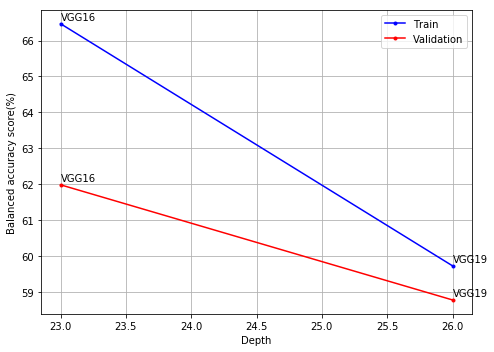

In [37]:
# Trainable params
model_layers = {
        'VGG16': 23, 
        'VGG19': 26, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5)
)

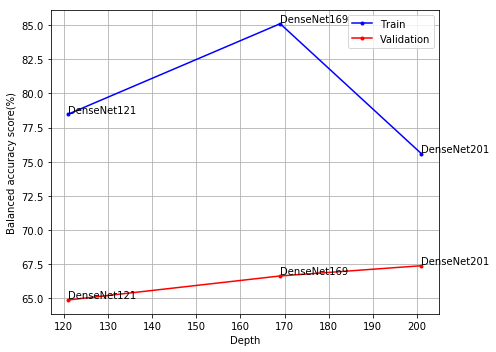

In [36]:
model_layers = {
    "DenseNet121": 121,
    "DenseNet169": 169,
    "DenseNet201": 201,
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5)
)

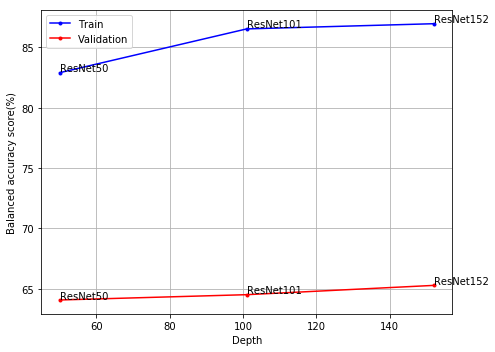

In [35]:
# Trainable params
model_layers = {
    "ResNet50": 50,
    "ResNet101": 101,
    "ResNet152": 152
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5)
)

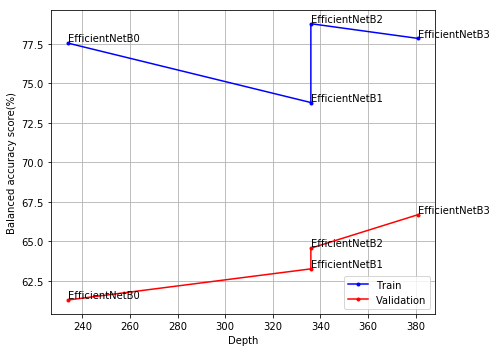

In [97]:
# Trainable params
model_layers = {
    'EfficientNetB0': 234,  
    "EfficientNetB1": 336,
    'EfficientNetB2': 336,
    'EfficientNetB3': 381,
    'EfficientNetB4': 471,
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Depth",
    metric_label="Balanced accuracy score(%)",
    figsize=(7,5)
)

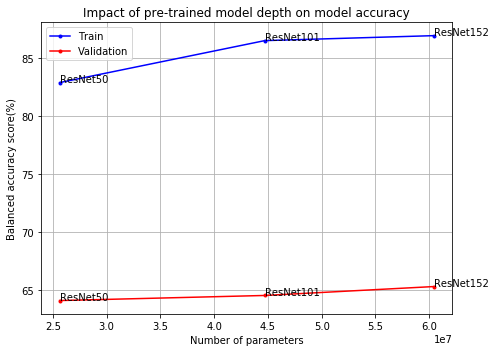

In [131]:
# Trainable params
model_layers = {
    "ResNet50": 25636712,
    "ResNet101": 44707176,
    "ResNet152": 60419944
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

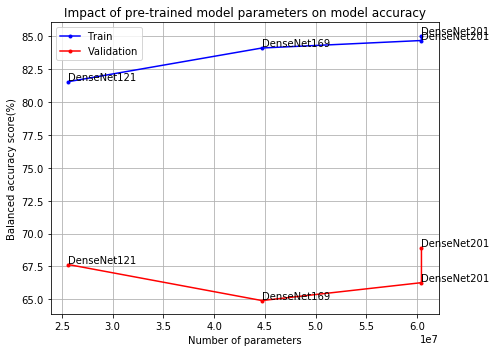

In [96]:
# Trainable params
model_layers = {
    "DenseNet121": 25636712,
    "DenseNet169": 44707176,
    "DenseNet201": 60419944
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftlr": "0.001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

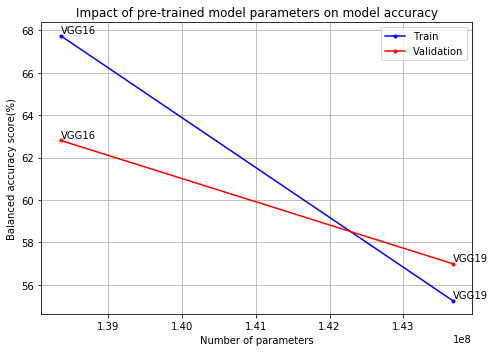

In [95]:
# Trainable params
model_layers = {
    'VGG16': 138357544, 
    'VGG19': 143667240, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 16
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

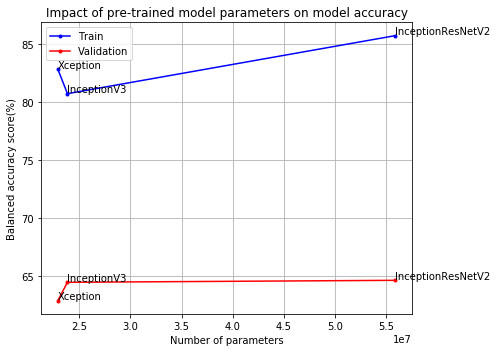

In [94]:
# Trainable params
model_layers = {
    'Xception': 22910480,  
    "InceptionV3": 23851784,
    'InceptionResNetV2': 55873736, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title="Impact of pre-trained model parameters on model accuracy"
)

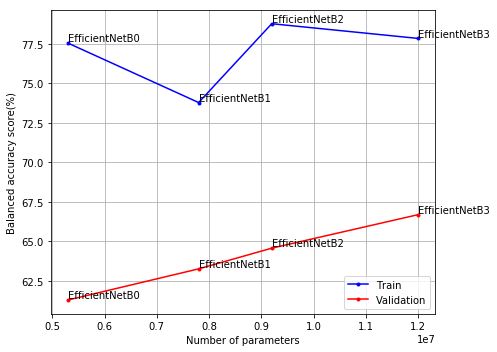

In [11]:
# Trainable params
model_layers = {
    'EfficientNetB0': 5300000,  
    "EfficientNetB1": 7800000,
    'EfficientNetB2': 9200000, 
    'EfficientNetB3': 12000000, 
}

filtered_models_info=filter_models_info(
    models_info, 
    [key for key, value in model_layers.items()], 
    parameters= {
        "balanced": "0",
        "samples": "5000",
        "feepochs": "0",
        "felr": "0.0001",
        "ftlr": "0.0001",
        "lambda": None,
        "dropout": None,
        "batch": 32
    }
)

fig = plot_model_parameter_comparisson(
    filtered_models_info,
    model_layers,
    parameter_label="Number of parameters",
    metric_label="Balanced accuracy score(%)",
    title=""
)

fig.savefig(os.path.join("efficientnet_params.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

## DenseNet201 - Confusion Matrix

Model selection criteria: best_balanced_acc

Train + validation sampled: 5000
Feature extract epochs: 0
Feature extract learning rate: 0.000100
Fine tuning learning rate: 0.000100
Dropout rate: None
Batch size: 32
	accuracy:  0.7420564436550227
	balanced_accuracy_score:  0.579451988235506


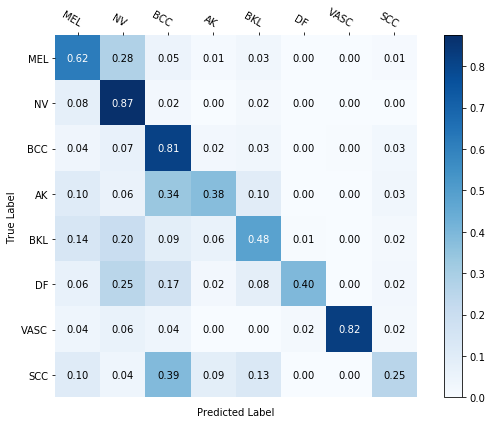

In [56]:
model_name = 'DenseNet201'
postfix = 'best_balanced_acc'

print(f'Model selection criteria: {postfix}\n')

model_info = filter_models_info(
    models_info, 
    models=["DenseNet201"],
    parameters={
        "samples": 5000,
        "balanced": 0,
        "lambda": None,
        "feepochs": 0, 
        "felr": 0.0001, 
        "ftlr": 0.0001, 
        "batch": 32,
        "dropout": None
    }
)[0]

print(f"Train + validation sampled: {model_info['hyperparameters']['samples']}")
print(f"Feature extract epochs: {model_info['hyperparameters']['feepochs']}")
print(f"Feature extract learning rate: {model_info['hyperparameters']['felr']}")
print(f"Fine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
print(f"Dropout rate: {model_info['hyperparameters']['dropout']}")
print(f"Batch size: {model_info['hyperparameters']['batch']}")

# Load predicted results
df_pred = pd.read_csv(os.path.join(model_info["pred_test"], "no_unknown", f"{postfix}.csv"))
df = pd.merge(df_pred, df_all_ground_truth, on='image')
y_true = df['category']
y_pred = df['pred_category']
df.to_csv("test.csv")

# Compute Balanced Accuracy
print('\taccuracy: ', accuracy_score(y_true, y_pred))
print('\tbalanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))

# Confusion Matrix
fig = plot_confusion_matrix(
    y_true, 
    y_pred, 
    known_category_names, 
    normalize=True,
    figsize=(8, 6)
)

fig.savefig(os.path.join("densenet201_untuned_conf_matrix.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)